In [1]:
import os
import json
import pandas as pd
import getpass
import re

from langchain_openai import ChatOpenAI
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage, RemoveMessage
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langchain.tools import BaseTool, StructuredTool, tool

from langgraph.checkpoint.sqlite import SqliteSaver

from pydantic import BaseModel, Field
from typing import Literal, Dict, Tuple, List, Optional, TypedDict, Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
import operator

# from llm_utils import get_llm

import itertools
import ast
from IPython.display import display, Markdown
import gradio as gr

import time

from dotenv import load_dotenv
load_dotenv("/home/jovyan/Albert/.env")

os.environ["OPENAI_API_KEY"] = os.environ.get("OPENAI_API_KEY")
# os.environ["SLIP_AUTH_URL"] = os.environ.get("SLIP_AUTH_URL")
# os.environ["SLIP_USERNAME"] =os.environ.get("SLIP_USERNAME")
# os.environ["SLIP_PASSWORD"] =  os.environ.get("SLIP_PASSWORD")
# os.environ["SLIP_CLIENT_ID"]= os.environ.get("SLIP_CLIENT_ID")
# os.environ["SLIP_APP_NAME"]=os.environ.get("SLIP_APP_NAME")

/home/jovyan/envs/llm_agents/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# We will save memory with sqlite saver
os.environ["TAVILY_API_KEY"] = "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"
tavily = TavilySearchResults(max_results=2)

## Format Data from CSV

In [3]:
df=pd.read_csv('~/data/LLM/EMR_LLM_data_combo_2204mcids_NEW.csv')

/home/jovyan/tmp/ipykernel_270141/2462326161.py:1: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('~/data/LLM/EMR_LLM_data_combo_2204mcids_NEW.csv')


In [4]:
df.columns = df.columns.str.lower()

df = df.rename(columns={'cd_desc': 'codeDesc'})

In [5]:
df['type'] = df['type'].replace('gpi', 'rx')

In [6]:
df.head()

,id,dos,type,code,value,abnormal_cd,codeDesc
0,33260,2019-10-23,EMR_Note,chief complaint,pre-op evaluation; hypertension. needs cx for ...,NaN,NaN
1,33260,2019-10-23,EMR_Note,past medical history,anemia of chronic disease. Percutaneous Corona...,NaN,NaN
2,33260,2019-11-16,EMR_Note,history of present illness,Pt is here for follow up from the hospital. Pt...,NaN,NaN
3,33260,2019-11-16,EMR_Note,physical exam,Cardiology Brief Exam. Basic Cardio PE:. HEENT...,NaN,NaN
4,33260,2019-11-16,EMR_Note,instructions,I10: Essential (primary) hypertension. 5: Hype...,NaN,NaN


In [7]:
df["type"].unique()

array(['EMR_Note', 'rx', 'lab', 'proc', 'diag', 'age', 'gender'],
      dtype=object)

In [8]:
idList = list(df["id"].unique())
print(len(idList))

2204


In [9]:
code_rows = df[(df["id"].isin(idList)) & (df["type"].isin(['rx', 'lab', 'proc', 'diag']))]

emr_rows = df[df["id"].isin(idList) & df["type"].isin(['EMR_Note'])]

gender_rows = df[df["id"].isin(idList) & df["type"].isin(['age', 'gender'])]

## Testing Agents
This will be multiple code agents that looks at the diag, proc, rx, and lab lookup table and history agnostically to get a summary, self-assigned LLM Q and A, and basic Q and A for the patient.

### Tools

In [10]:
from typing import List, Dict

@tool
def returnSpecificICD10DatesCodes(patient_codes_list: List[List[str]], dates_list: List[str], codes_disease_dictionary_mapping: Dict[str, str], diseaseSearch: str) -> Tuple[List[str], List[List[str]], List[str]]:
    """returns the patient's specific ICD10 codes and dates for the disease searched based on their existing dates and codes."""
    # Extract the specific disease codes from the dictionary mapping
    check = set([code for code, disease in codes_disease_dictionary_mapping.items() if disease == diseaseSearch])

    filtered_dates = []
    filtered_code_lists = []
    specificDiseaseCodesFound = set()

    # Filtering the dates and code lists based on the disease search
    for i, codes in enumerate(patient_codes_list):
        intersection = set(codes) & check
        if intersection:
            filtered_code_lists.append(list(intersection))
            filtered_dates.append(dates_list[i])
            specificDiseaseCodesFound.update(intersection)

    return filtered_dates, filtered_code_lists, list(specificDiseaseCodesFound)

In [11]:
# create codes in alphanumeric order.

# lookup_dict is like : Dict[str, str]
@tool
def createLookupTable(codes: List[List[str]], lookup_dict) -> str:
    """Create the codes and descriptions lookup table for the specific patient."""
    
    
    # print(codes)
    # print(lookup_dict)
    
    flattened_list = [item for sublist in codes for item in sublist]
    
    # get unique codes, which are keys in lookup_dict
    unique_codes = set(flattened_list) & lookup_dict.keys()
    # print("Unique Codes 777", unique_codes)
    
    # sort codes in alphanumeric order
    sorted_unique_codes = sorted(unique_codes)
    
    # join each code and its description in a string, separated by ":"
    formatted_string = " \n ".join(f"{code}: {lookup_dict[code]}" for code in sorted_unique_codes)
    
    # print("FORMATTED STRING", formatted_string)

    return formatted_string

In [12]:
from typing import List, Dict

@tool
def createLabLookupTable(codes: List[Dict], lookup_dict: Dict) -> str:
    """Create the codes and descriptions lookup table for the specific patient."""
    
    
    # Flatten dict to create list of all codes
    flattened_list = [key for sublist in codes for key in sublist]
    
    # get unique codes, which are keys in lookup_dict
    unique_codes = set(flattened_list) & set(lookup_dict.keys())
    
    # print("Unique Codes 777", unique_codes)
    
    # sort codes in alphanumeric order
    sorted_unique_codes = sorted(unique_codes)
    
    # join each code and its description in a string, separated by ":"
    formatted_string = " \n ".join(f"{code}: {lookup_dict[code]}" for code in sorted_unique_codes)
    
    # print(formatted_string)
    
    return formatted_string


In [13]:
@tool
def createLabCodeHistory(dates: List[str], codes: List[Dict]) -> str:
    """Create the visit dates and medical codes history list for the specific patient."""
    return " \n ".join(
    f"{date}: [{', '.join(f'{k}: {v}' for k, v in code.items())}]"
    for date, code in zip(dates, codes)
    )

In [14]:
@tool
def createCodeHistory(dates: List[str], codes: List[List[str]]) -> str:
    """Create the visit dates and medical codes history list for the specific patient."""
    return ' \n '.join(
       f"{date}: {', '.join(map(str, codes))}" 
       for date, codes in zip(dates, codes)
    )


In [15]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import base64
import io
from PIL import Image as PIL_Image

def try_float(val, default=False):
    """
    Try to convert a value to float.
    Return the float value on success, 'default' value on fail.
    """
    try:
        return float(val)
    except ValueError:
        return default

def labVizData(lab_code: str, lab_description: str, lab_unit_measurement: str, plot_name: str, dates, lab_values):
    # Initialize lists to store the code values, associated dates, and codes.
    code_values = []
    date_values = []

    abnormalCode = []
    # Iterate over each dictionary in the lab_values list along with the index
    for i, lab_dict in enumerate(lab_values):
        # For each dictionary, fetch the first key and value (assuming each dictionary has only one pair).
        # Take care of the case if the dictionary is empty.
        if lab_code in lab_dict:
            value = lab_dict[lab_code][0]  # Assuming try_float is a function that attempts to convert a string to a float and returns None or False if it fails.        
            # if value is not False:   
            # Append to code_values, dates, and codes lists
            code_values.append(float(value))
            date_values.append(dates[i])
            abnormalCode.append(lab_dict[lab_code][1])
            

    if len(code_values) > 0:
        ax = plt.gca()
        x_axis = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in date_values]
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
        ax.set_xticks(x_axis)
        plt.figure(figsize=(12, 8))  # Adjust the width and height as needed
        plt.xlabel("Dates")
        plt.ylabel("Values")
        plt.title(lab_code+" (" + lab_description + ")")
        plt.plot(x_axis, code_values, '--bo')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
        
        
        
        for i, value in enumerate(code_values):
            if abnormalCode[i] == "H":
                plt.annotate(abnormalCode[i], (x_axis[i], code_values[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='red')
            elif abnormalCode[i] == "L":
                plt.annotate(abnormalCode[i], (x_axis[i], code_values[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='red')
            else:
                plt.annotate(abnormalCode[i], (x_axis[i], code_values[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)
            
            

        
        plt.savefig(plot_name, format="png")
        plt.close()
    else:
        return "Patient does not have any "+ lab_code + " data."
    
    return "![" + lab_description + "](" + plot_name+")"

@tool
def labViz(lab_code: str, lab_description: str, lab_unit_measurement: str, plot_name: str):
    """A lab test graphing visualization tool patient's medical history. lab_code must be the exact lab_code name. \ 
Will save an image in the format where plot_name looks like 'plot_name.png'. \
Useful for when you need to answer questions with a visualization of a specific lab test's values. \ 
Inputs are lab_code (the lab test code name), lab_description (description/name of lab test), \
lab_unit_measurement (unit of measurement for lab values), plot_name (save the plot as plot_name.png)"""
        
    return lab_code, lab_description, lab_unit_measurement, plot_name


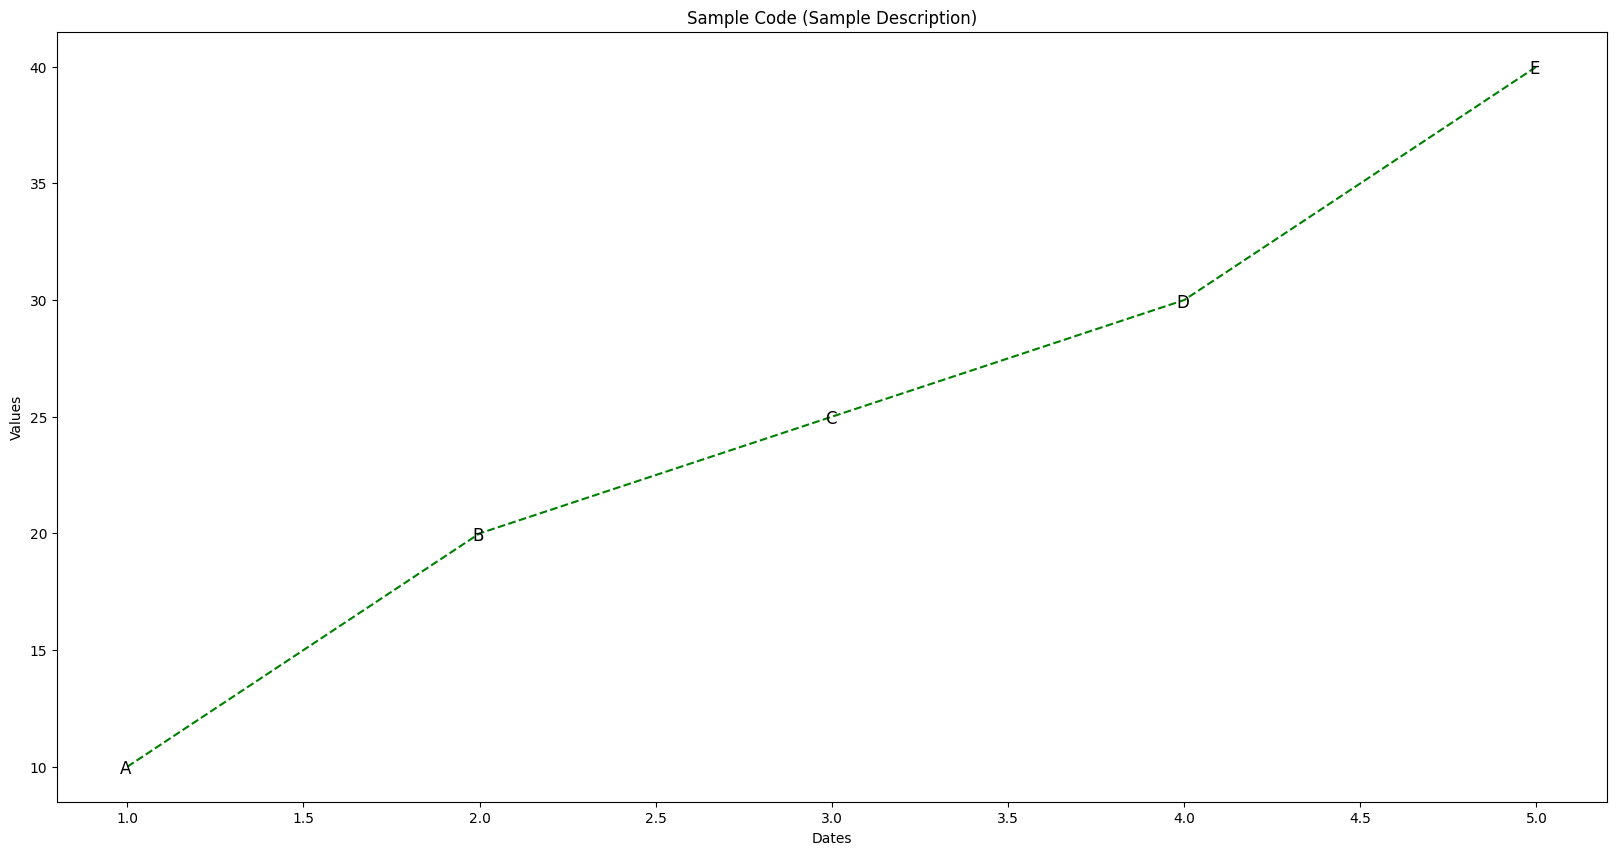

In [16]:
import matplotlib.pyplot as plt

# Sample data
x_axis = [1, 2, 3, 4, 5]
code_values = [10, 20, 25, 30, 40]
lab_code = "Sample Code"
lab_description = "Sample Description"
# Text labels for each point
text_labels = ["A", "B", "C", "D", "E"]
# Set the size of the figure
plt.figure(figsize=(20, 10))  # Adjust the width and height as needed
plt.xlabel("Dates")
plt.ylabel("Values")
plt.title(lab_code + " (" + lab_description + ")")

# Plot the line without markers
plt.plot(x_axis, code_values, linestyle='--', color='g') 

# Annotate each point with the corresponding text label in place of dots
for i, txt in enumerate(text_labels):
    plt.annotate(txt, (x_axis[i], code_values[i]), textcoords="offset points", xytext=(-1,-5), ha='center', fontsize=12)

plt.show()


## Prompts

In [17]:
DIAG_SUMMARY_PROMPT = """
Instructions:
1. Output the JSON string based on the "Patient Diag Code Table" using the provided "Output Format Json."
2. Organize the most relevant codes together in specific categories that provide value to the health professional reviewing them.
3. Ensure the JSON string is correctly formatted without extra characters or markdown.
4. Include all codes from the "Patient Diag Code Table."
5. Prioritize more serious categories and conditions at the beginning of the JSON output

Input Format for "Patient Diag Code Table":
'''
diagCode1: description of diag code 1
diagCode2: description of diag code 2
etc.
'''

Patient Diag Code Table:
{lookupTable}

Output Format Json:

{{
  "diagCategories": [
    {{
      "category": "Category Name 1",
      "values": [
        {{
          "name": "Diag Name 1",
          "code": "diagCode1"
        }},
        {{
          "name": "Diag Name 2",
          "code": "diagCode2"
        }}
      ]
    }},
    {{
      "category": "Category Name 2",
      "values": [
        {{
          "name": "Diag Name 3",
          "code": "diagCode3"
        }},
        {{
          "name": "Diag Name 4",
          "code": "diagCode4"
        }}
      ]
    }}
    # Continue with additional categories and values as necessary
  ]
}}
""".strip()


In [18]:
RX_SUMMARY_PROMPT = """
Instructions:
1. Output the JSON string based on the "Patient Rx Code Table" using the provided "Output Format Json."
2. Organize the most relevant codes together in categories.
3. Ensure the JSON string is correctly formatted without extra characters or markdown.
4. Include all codes from the "Patient Rx Code Table."
5. Prioritize more serious categories and conditions at the beginning of the JSON output

Input Format for "Patient Rx Code Table":
'''
rxCode1: description of rx code 1
rxCode2: description of rx code 2
etc.
'''

Patient Rx Code Table:
{lookupTable}

Output Format Json:

{{
  "rxCategories": [
    {{
      "category": "Category Name 1",
      "values": [
        {{
          "name": "Rx Name 1",
          "code": "rxCode1"
        }},
        {{
          "name": "Rx Name 2",
          "code": "rxCode2"
        }}
      ]
    }},
    {{
      "category": "Category Name 2",
      "values": [
        {{
          "name": "Rx Name 3",
          "code": "rxCode3"
        }},
        {{
          "name": "Rx Name 4",
          "code": "rxCode4"
        }}
      ]
    }}
    # Continue with additional categories and values as necessary
  ]
}}
""".strip()


In [19]:
PROC_SUMMARY_PROMPT = """
Instructions:
1. Output the JSON string based on the "Patient Proc Code Table" using the provided "Output Format Json."
2. Organize the most relevant codes together in categories.
3. Ensure the JSON string is correctly formatted without extra characters or markdown.
4. Include all codes from the "Patient Proc Code Table."
5. Prioritize more serious categories and conditions at the beginning of the JSON output

Input Format for "Patient Proc Code Table":
'''
procCode1: description of proc code 1
procCode2: description of proc code 2
etc.
'''

Patient Proc Code Table:
{lookupTable}

Output Format Json:

{{
  "procCategories": [
    {{
      "category": "Category Name 1",
      "values": [
        {{
          "name": "proc Name 1",
          "code": "procCode1"
        }},
        {{
          "name": "proc Name 2",
          "code": "procCode2"
        }}
      ]
    }},
    {{
      "category": "Category Name 2",
      "values": [
        {{
          "name": "proc Name 3",
          "code": "procCode3"
        }},
        {{
          "name": "proc Name 4",
          "code": "procCode4"
        }}
      ]
    }}
    # Continue with additional categories and values as necessary
  ]
}}
""".strip()


In [20]:
LAB_SUMMARY_PROMPT = """
Instructions:
1. Output the JSON string based on the "Patient Lab Code Table" using the provided "Output Format Json."
2. Organize the most relevant codes together in categories.
3. Ensure the JSON string is correctly formatted without extra characters or markdown.
4. Include all codes from the "Patient Lab Code Table."
5. Prioritize more serious categories and conditions at the beginning of the JSON output

Input Format for "Patient Lab Code Table":
'''
labCode1: description of lab code 1
labCode2: description of lab code 2
etc.
'''

Patient Lab Code Table:
{lookupTable}

Output Format Json:

{{
  "labCategories": [
    {{
      "category": "Category Name 1",
      "values": [
        {{
          "name": "lab Name 1",
          "code": "labCode1",
        }},
        {{
          "name": "lab Name 2",
          "code": "labCode2"
        }}
      ]
    }},
    {{
      "category": "Category Name 2",
      "values": [
        {{
          "name": "lab Name 3",
          "code": "labCode3"
        }},
        {{
          "name": "lab Name 4",
          "code": "labCode4"
        }}
      ]
    }}
    # Continue with additional categories and values as necessary
  ]
}}
""".strip()


## Agent States

In [21]:
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    
    # print("left", left)
    # print("right", right)
    # print()
    # print("-----------------")
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    
    # print("MERGED")
    for message in right:
        print(message)
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
            
    # print("END OF MERGED")
    return merged

class AgentState(TypedDict):
    mcid: int
    verbose: int
    
    lookup_dict_diag: Dict[str, str]
    dates_diag: List[List[str]]
    codes_diag: List[List[int]]
    
    lookup_dict_rx: Dict[str, str]
    dates_rx: List[List[str]]
    codes_rx: List[List[int]]
    
    lookup_dict_proc: Dict[str, str]
    dates_proc: List[List[str]]
    codes_proc: List[List[int]]
    
    lookup_dict_lab: Dict[str, str]
    dates_lab: List[List[str]]
    codes_lab: List[Dict[str, str]]
    
    EMR_Notes: str
    
    messages: Annotated[List[AnyMessage], reduce_messages]
    

## Summary Agent Graph

In [22]:
class SummaryAgent():
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        
        graph = StateGraph(AgentState)
        # Diag Code Related
        graph.add_node("Diagnosis Summary", self.diag_general_summary)
        
        # Rx Code Related
        graph.add_node("Rx Summary", self.rx_general_summary)

        # Proc Code Related
        graph.add_node("Procedure Summary", self.proc_general_summary)
        
        # Lab Code Relatled
        graph.add_node("Lab Summary", self.lab_general_summary)
        
        # EMR Note
        graph.add_node("HOS Summary", self.EMR_HOS_summary)
    

        graph.add_edge(START, "Diagnosis Summary")
        graph.add_edge(START, "Rx Summary")
        graph.add_edge(START, "Procedure Summary")
        graph.add_edge(START, "Lab Summary")
        graph.add_edge(START, "HOS Summary")
        
        graph.add_edge("Diagnosis Summary", END)
        graph.add_edge("Rx Summary", END)
        graph.add_edge("Procedure Summary", END)
        graph.add_edge("Lab Summary", END)
        graph.add_edge("HOS Summary", END)
        
        self.graph = graph.compile(
            checkpointer=checkpointer,
        )
        
        self.tools = {t.name: t for t in tools}
        self.model = model
        self.model_with_tools = model.bind_tools(tools)
        
    def diag_general_summary(self, state: AgentState):
        
        start_time = time.time()
        if len(state["codes_diag"]) == 0:
            return {'messages': [AIMessage(content="No diag codes.")]}
        else:
            message = [
            SystemMessage(content=self.system), 
            HumanMessage(content=DIAG_SUMMARY_PROMPT.format( \
                lookupTable = self.tools['createLookupTable'].invoke({"codes": state['codes_diag'], "lookup_dict": state['lookup_dict_diag']}))) #, \
                # codeHistory = self.tools['createCodeHistory'].invoke({"dates": state['dates_diag'], "codes": state['codes_diag']})))
            ]
            
            print("TIME DIAGNOSIS 1: ", time.time()-start_time)

            # print("Human Message", message)
            response = self.model.invoke(message)
            
            print("TIME DIAGNOSIS 2: ", time.time()-start_time)
        
            # print("-------")
            # print()
            # print("Response", response.content)
            # print()
            # print("-------")
            tempJson = json.loads(response.content.strip('```json').strip('```').strip())
            
            # print(tempJson)
            
            # Check for missing codes by LLM, if so we recall the LLM to categorize the missing codes
            incorrectCodes,  missingCodesDict, codesFound, categories = find_missing_codes(tempJson, state['lookup_dict_diag'])
            
            totalMissingCodes = []
            totalMissingCodes.append(missingCodesDict)
            totalIncorrectCodes = []
            totalIncorrectCodes.append(incorrectCodes)
            
            print("TIME DIAGNOSIS 3: ", time.time()-start_time)
            
            count = 0
            while (len(missingCodesDict) > 0 or len(incorrectCodes) > 0) and count < 3:
                
                checkResponse = recall(llm, recall_prompt.format(codeType="diagnosis", categories=categories, codes=missingCodesDict))
                checkJson = json.loads(checkResponse.content.strip('```json').strip('```').strip())
                
                print("Iteration " + str(count) + " # missing codes: ", len(missingCodesDict))
                print("missing codes:", missingCodesDict)
                print("incorrectCodes:", incorrectCodes)
                
                # merge the new recalled categorization from the missing values
                mergedJson = merge_json_data(tempJson[list(tempJson.keys())[0]], checkJson)
                tempJson[list(tempJson.keys())[0]] = mergedJson
                
                # Check again with the new updated tempJson
                incorrectCodes,  missingCodesDict, codesFound, categories = find_missing_codes(tempJson, state['lookup_dict_diag'])
                totalMissingCodes.append(missingCodesDict)
                totalIncorrectCodes.append(incorrectCodes)
                
                count+=1
                
            print("TIME DIAGNOSIS 4: ", time.time()-start_time)

                
            markdownSummary = json_to_markdown(tempJson, state['codes_diag'], state['dates_diag'], state['lookup_dict_diag'], categoryName="diagCategories", missingCodes=totalMissingCodes, incorrectCodes=totalIncorrectCodes, title="# Diagnosis Categories\n")
            
            print("TIME DIAGNOSIS 5: ", time.time()-start_time)
            return {"messages": [AIMessage(content=markdownSummary)]}
    
    def rx_general_summary(self, state: AgentState):
        if len(state["codes_rx"]) == 0:
            return {'messages': [AIMessage(content="No rx codes.")]}
        
        else:
            message = [
            SystemMessage(content=self.system), 
            HumanMessage(content=RX_SUMMARY_PROMPT.format( \
                lookupTable = self.tools['createLookupTable'].invoke({"codes": state['codes_rx'], "lookup_dict": state['lookup_dict_rx']}))) #, \
                # codeHistory = self.tools['createCodeHistory'].invoke({"dates": state['dates_rx'], "codes": state['codes_rx']})))
            ]
            response = self.model.invoke(message)
            
            tempJson = json.loads(response.content.strip('```json').strip('```').strip())
            
            # Check for missing codes by LLM, if so we recall the LLM to categorize the missing codes
            incorrectCodes,  missingCodesDict, codesFound, categories = find_missing_codes(tempJson, state['lookup_dict_rx'])
            
            totalMissingCodes = []
            totalMissingCodes.append(missingCodesDict)
            totalIncorrectCodes = []
            totalIncorrectCodes.append(incorrectCodes)
            
            count = 0
            while (len(missingCodesDict) > 0 or len(incorrectCodes) > 0) and count < 3:
                
                checkResponse = recall(llm, recall_prompt.format(codeType="Rx", categories=categories, codes=missingCodesDict))
                checkJson = json.loads(checkResponse.content.strip('```json').strip('```').strip())
                
                print("Iteration " + str(count) + " # missing codes: ", len(missingCodesDict))
                print("missing codes:", missingCodesDict)
                print("incorrectCodes:", incorrectCodes)
                
                # merge the new recalled categorization from the missing values
                mergedJson = merge_json_data(tempJson[list(tempJson.keys())[0]], checkJson)
                tempJson[list(tempJson.keys())[0]] = mergedJson
                
                # Check again with the new updated tempJson
                incorrectCodes,  missingCodesDict, codesFound, categories = find_missing_codes(tempJson, state['lookup_dict_rx'])
                totalMissingCodes.append(missingCodesDict)
                totalIncorrectCodes.append(incorrectCodes)
                
                count+=1
            
            
            markdownSummary = json_to_markdown(tempJson, state['codes_rx'], state['dates_rx'], state['lookup_dict_rx'], categoryName="rxCategories", missingCodes=totalMissingCodes, incorrectCodes=totalIncorrectCodes, title="# Rx Categories\n")
            return {"messages": [AIMessage(content=markdownSummary)]}
    
    def proc_general_summary(self, state: AgentState):
               
        if len(state["codes_proc"]) == 0:
            return {'messages': [AIMessage(content="No proc codes.")]}
        
        else:
            message = [
            SystemMessage(content=self.system), 
            HumanMessage(content=PROC_SUMMARY_PROMPT.format( \
                lookupTable = self.tools['createLookupTable'].invoke({"codes": state['codes_proc'], "lookup_dict": state['lookup_dict_proc']}))) #, \
                # codeHistory = self.tools['createCodeHistory'].invoke({"dates": state['dates_proc'], "codes": state['codes_proc']})))
            ]
            response = self.model.invoke(message)
            
            tempJson = json.loads(response.content.strip('```json').strip('```').strip())
            
            # Check for missing codes by LLM, if so we recall the LLM to categorize the missing codes
            incorrectCodes,  missingCodesDict, codesFound, categories = find_missing_codes(tempJson, state['lookup_dict_proc'])
            
            totalMissingCodes = []
            totalMissingCodes.append(missingCodesDict)
            totalIncorrectCodes = []
            totalIncorrectCodes.append(incorrectCodes)
            
            count = 0
            while (len(missingCodesDict) > 0 or len(incorrectCodes) > 0) and count < 3:
                
                checkResponse = recall(llm, recall_prompt.format(codeType="Procedure", categories=categories, codes=missingCodesDict))
                
                # print("-------------------")
                # print("Content")
                # print()
                # print(checkResponse.content)
                # print()
                # print()
                # print("-------------------")
                checkJson = json.loads(checkResponse.content.strip('```json').strip('```').strip())
                
                print("Iteration " + str(count) + " # missing codes: ", len(missingCodesDict))
                print("missing codes:", missingCodesDict)
                print("incorrectCodes:", incorrectCodes)
                
                # merge the new recalled categorization from the missing values
                mergedJson = merge_json_data(tempJson[list(tempJson.keys())[0]], checkJson)
                tempJson[list(tempJson.keys())[0]] = mergedJson
                
                # Check again with the new updated tempJson
                incorrectCodes,  missingCodesDict, codesFound, categories = find_missing_codes(tempJson, state['lookup_dict_proc'])
                totalMissingCodes.append(missingCodesDict)
                totalIncorrectCodes.append(incorrectCodes)
                
                count+=1
                
                
            markdownSummary = json_to_markdown(tempJson, state['codes_proc'], state['dates_proc'], state['lookup_dict_proc'], categoryName="procCategories", missingCodes=totalMissingCodes, incorrectCodes=totalIncorrectCodes, title="# Procedure Categories\n")
        
            return {"messages": [AIMessage(content=markdownSummary)]}
    
    def lab_general_summary(self, state: AgentState):
            
        if len(state["codes_lab"]) == 0:
            return {'messages': [AIMessage(content="No lab codes.")]}
        
        else:
            message = [
            SystemMessage(content=self.system), 
            HumanMessage(content=LAB_SUMMARY_PROMPT.format( \
                lookupTable = self.tools['createLabLookupTable'].invoke({"codes": state['codes_lab'], "lookup_dict": state['lookup_dict_lab']}))) #, \
                # codeHistory = self.tools['createLabCodeHistory'].invoke({"dates": state['dates_lab'], "codes": state['codes_lab']}))) 
            ]
            response = self.model.invoke(message)
            # print(response)
            
            tempJson = json.loads(response.content.strip('```json').strip('```').strip())
            
           # Check for missing codes by LLM, if so we recall the LLM to categorize the missing codes
            incorrectCodes,  missingCodesDict, codesFound, categories = find_missing_codes(tempJson, state['lookup_dict_lab'])
            
            totalMissingCodes = []
            totalMissingCodes.append(missingCodesDict)
            totalIncorrectCodes = []
            totalIncorrectCodes.append(incorrectCodes)
            
            count = 0
            while (len(missingCodesDict) > 0 or len(incorrectCodes) > 0) and count < 3:
                
                checkResponse = recall(llm, recall_prompt.format(codeType="Lab", categories=categories, codes=missingCodesDict))
                checkJson = json.loads(checkResponse.content.strip('```json').strip('```').strip())
                
                print("Iteration " + str(count) + " # missing codes: ", len(missingCodesDict))
                print("missing codes:", missingCodesDict)
                print("incorrectCodes:", incorrectCodes)
                
                # merge the new recalled categorization from the missing values
                mergedJson = merge_json_data(tempJson[list(tempJson.keys())[0]], checkJson)
                tempJson[list(tempJson.keys())[0]] = mergedJson
                
                # Check again with the new updated tempJson
                incorrectCodes,  missingCodesDict, codesFound, categories = find_missing_codes(tempJson, state['lookup_dict_lab'])
                totalMissingCodes.append(missingCodesDict)
                totalIncorrectCodes.append(incorrectCodes)
                count+=1
            
            
            markdownSummary = json_to_markdown(tempJson, state['codes_lab'], state['dates_lab'], state['lookup_dict_lab'], categoryName="labCategories", missingCodes=totalMissingCodes, incorrectCodes=totalIncorrectCodes, title="# Lab Categories\n", isLab=True)
            return {"messages": [AIMessage(content=markdownSummary)]}
        
    def EMR_HOS_summary(self, state: AgentState):
        
        totalResponse = ""
        
        # Monitoring physical activity
        message = [
        SystemMessage(content=self.system), 
        HumanMessage(content=PHYSICAL_ACTIVITY_C04.format(EMR=state['EMR_Notes']))
        ]
        response = self.model.invoke(message)
        json_data = json.loads(response.content.strip('```json').strip('```').strip())
        if json_data["questions_and_answers"]["42"]["answer"] == "No":
            json_data["questions_and_answers"]["43"]["answer"] = "NA"
        markdown_output = json_to_markdown_EMR_HOS(json_data, HOS_dict)
        
        totalResponse = "# STAR Measures: Health Outcomes Survey (HOS) \n ## Monitoring Physical Activity \n" + markdown_output + "\n"
        
        # Reducing the risk of falling
        message = [
        SystemMessage(content=self.system), 
        HumanMessage(content=RISK_FALLING_C12.format(EMR=state['EMR_Notes']))
        ]
        response = self.model.invoke(message)
        json_data = json.loads(response.content.strip('```json').strip('```').strip())
        if json_data["questions_and_answers"]["45"]["answer"] == "No" and json_data["questions_and_answers"]["46"]["answer"] == "No":
            json_data["questions_and_answers"]["47"]["answer"] = "NA"
            
        if json_data["questions_and_answers"]["44"]["answer"] == "No":
            json_data["questions_and_answers"]["47"]["answer"] = "NA"
        markdown_output = json_to_markdown_EMR_HOS(json_data, HOS_dict)
        
        totalResponse = totalResponse + "\n ## Reducing the Risk of Falling \n" + markdown_output + "\n"
        
        # Improving bladder control
        message = [
        SystemMessage(content=self.system), 
        HumanMessage(content=BLADDER_CONTROL_C13.format(EMR=state['EMR_Notes']))
        ]
        response = self.model.invoke(message)
        json_data = json.loads(response.content.strip('```json').strip('```').strip())
        if json_data["questions_and_answers"]["38"]["answer"] == "No":
            json_data["questions_and_answers"]["41"]["answer"] = "NA"
        markdown_output = json_to_markdown_EMR_HOS(json_data, HOS_dict)
        
        totalResponse = totalResponse + "\n ## Improving Bladder Control \n" + markdown_output
        
        
        return {"messages": [AIMessage(content=totalResponse)]}
        
        
        
        

In [23]:
def json_to_markdown_EMR_HOS(json_data, question_text, wrap_width=120):
    markdown_output = ""

    for question_id, qa in json_data.get("questions_and_answers", {}).items():
        answer = qa.get("answer", "Not enough information")
        justification = qa.get("justification", "")
        markdown_output += f"**HOS Q"+ str(question_id)+ f":** " + f"{question_text[question_id]}\n"
        markdown_output += f"  - **{answer}** \n"
        markdown_output += f"  - **Justification:** {justification}\n\n"

    return markdown_output
    
    

In [24]:
HOS_dict = {"38": """In the past 12 months, have you experienced leaking of urine?""",
            "41": """Have you talked with a doctor, nurse, or other health care provider about ways (e.g. exercise, medication, surgery) to help control or manage your bladder?""",
            "42": """In the past 12 months, have you talked with a doctor or other health provider about your level of exercise or physical activity?""",
            "43": """In the past 12 months, did a doctor or other health care provider advise you to start, increase or maintain your level of exercise or physical activity?""",
            "44": """In the past 12 months, did you talk with your doctor or other health provider about falling or problems with balance or walking?""",
            "45": """Have you fallen in the past 12 months?""",
            "46": """In the past 12 months, have you had a problem with balance or walking?""",
            "47": """Has your doctor or other health provider done anything to help prevent falls or treat problems with balance or walking?"""}

# HOS_dict = {
#     "38": "In the past, have you experienced **leaking of urine**?",
#     "41": "Have you **talked with a doctor, nurse, or other health care provider** about ways (e.g. exercise, medication, surgery) to help **control or manage your bladder**?",
#     "42": "In the past, have you **talked with a doctor or other health provider** about your level of **exercise or physical activity**?",
#     "43": "In the past, did a **doctor or other health care provider** **advise** you to **start, increase or maintain** your level of **exercise or physical activity**?",
#     "44": "In the past, did you **talk with your doctor or other health provider** about **falling or problems with balance or walking**?",
#     "45": "Have you **fallen** in the past?",
#     "46": "In the past, have you had a **problem with balance or walking**?",
#     "47": "Has your **doctor or other health provider** done anything to **help prevent falls** or **treat problems with balance or walking**?"
# }


In [25]:
# HOS_dict = {"38": """Many people experience leaking of urine, also called urinary incontinence. In the past six months, have you experienced leaking of urine?""",
#             "41": """There are many ways to control or manage the leaking of urine, including bladder training exercises, medication and surgery. Have you ever talked with a doctor, nurse, or other health care provider about any of these approaches?""",
#             "42": """In the past 12 months, did you talk with a doctor or other health provider about your level of exercise or physical activity? For example, a doctor or other health provider may ask if you exercise regularly or take part in physical exercise.""",
#             "43": """In the past 12 months, did a doctor or other health care provider advise you to start, increase or maintain your level of exercise or physical activity? For example, in order to improve your health, your doctor or other health provider may advise you to start taking the stairs, increase walking from 10 to 20 minutes every day or to maintain your current exercise program.""",
#             "44": """A fall is when your body goes to the ground without being pushed. In the past 12 months, did you talk with your doctor or other health provider about falling or problems with balance or walking?""",
#             "45": """Did you fall in the past 12 months?""",
#             "46": """In the past 12 months have you had a problem with balance or walking?""",
#             "47": """Has your doctor or other health provider done anything to help prevent falls or treat problems with balance or walking? Some things they might do include: <ul><li>Suggest that you use a cane or walker.</li><li> Suggest that you do an exercise or physical therapy program. </li><li> Suggest a vision or hearing test.</li></ul>""" 
# }
# print(HOS_dict["47"])

In [26]:
PHYSICAL_ACTIVITY_C04 = """
Instructions:
1. Given the patient's EMR notes, answer HOS survey questions 42 and 43 for the HEDIS-HOS measure "monitoring physical activity (c04)."
2. Provide evidence/references to which EMR notes substantiate claims to answer the HOS survey questions.
3. List very detailed evidence and every piece of evidence you find.
4. Follow the output format.

HOS Survey Question 42: In the past 12 months, did you talk with a doctor or other
health provider about your level of exercise or physical activity? For example, a doctor
or other health provider may ask if you exercise regularly or take part in physical
exercise.
HOS Survey Question 43: In the past 12 months, did a doctor or other health care
provider advise you to start, increase or maintain your level of exercise or physical
activity? For example, in order to improve your health, your doctor or other health
provider may advise you to start taking the stairs, increase walking from 10 to 20
minutes every day or to maintain your current exercise program.

Output Format:
{{
    "name": "Monitoring Physical Activity",
    "questions_and_answers": {{
      "42": {{
        "answer": "Yes" / "No" / "Not enough information"
        "justification": 
      }},
      "43": {{
        "answer": "Yes" / "No" / "Not enough information"
        "justification": 
      }}
    }}
}}

Patient EMR notes 
{EMR}
"""

In [27]:
RISK_FALLING_C12 = """
Instructions:
1. Given the patient's EMR notes, answer HOS survey questions 44, 45, 46, and 47 for the HEDIS-HOS measure "reducing the risk of falling (c12)."
2. Provide evidence/references to which EMR notes substantiate claims to answer the HOS survey questions. 
3. List very detailed evidence and every piece of evidence you find.
4. Follow the output format.

HOS Survey Question 44: A fall is when your body goes to the ground without being
pushed. In the past 12 months, did you talk with your doctor or other health provider
about falling or problems with balance or walking?
HOS Survey Question 45: Did you fall in the past 12 months?
HOS Survey Question 46: In the past 12 months have you had a problem with balance
or walking?
HOS Survey Question 47: Has your doctor or other health provider done anything to
help prevent falls or treat problems with balance or walking? Some things they might do
include:
 • Suggest that you use a cane or walker.
 • Suggest that you do an exercise or physical therapy program.
 • Suggest a vision or hearing test.
 
Output Format:
{{
    "name": "Reducing the Risk of Falling",
    "questions_and_answers": {{
      "44": {{
        "answer": "Yes" / "No" / "Not enough information"
        "justification": 
      }},
      "45": {{
        "answer": "Yes" / "No" / "Not enough information"
        "justification":
      }},
      "46": {{
        "answer": "Yes" / "No" / "Not enough information"
        "justification": 
      }},
      "47": {{
        "answer": "Yes" / "No" / "Not enough information"
        "justification":
      }}
    }}
}}

Patient EMR notes 
{EMR}
"""

In [28]:
BLADDER_CONTROL_C13 = """
Instructions:
1. Given the patient's EMR notes, answer HOS survey questions 38 and 41 for the HEDIS-HOS measure "improving bladder control (c13)."
2. Provide evidence/references to which EMR notes substantiate claims to answer the HOS survey questions.
3. List very detailed evidence and every piece of evidence you find.
4. Follow the output format.

HOS Survey Question 38: Many people experience leaking of urine, also called urinary
incontinence. In the past six months, have you experienced leaking of urine?
HOS Survey Question 41: There are many ways to control or manage the leaking of
urine, including bladder training exercises, medication and surgery. Have you ever
talked with a doctor, nurse, or other health care provider about any of these
approaches?
Member choices must be as follows to be included in the denominator:
 • Q38 = "Yes."
 • Q41 = "Yes" or "No."
The numerator contains the number of members in the denominator who indicated they
discussed treatment options for their urinary incontinence with a health care provider.
Member choice must be as follows to be included in the numerator:
 • Q41 = "Yes."
Data Source Category: Survey of Enrollees

Output Format:
{{
    "name": "Improving Bladder Control",
    "questions_and_answers": {{
      "38": {{
        "answer": "Yes" / "No" / "Not enough information"
        "justification": 
      }},
      "41": {{
        "answer": "Yes" / "No" / "Not enough information"
        "justification":
      }}
    }}
}}

Patient EMR notes 
{EMR}
"""

In [29]:
# Function to create the desired formatted string
def create_string_from_dataframe(df):
    message = ""
    
    for index, row in df.iterrows():
        message += f"{row['code']} - {row['dos']}\n"
        message += f"{row['value']}\n\n"
        
    return message.strip()

## Past, Present, and Future Conditions

In [30]:
PAST_SUMMARY =  (
"1. Review the outputs from the basic info, diagnosis, procedure, medication, and lab test agents.\n"
"2. Identify and list all past medical conditions based on the patient's medical history.\n"
"3. Prioritize the past conditions based on their significance and impact on the patient's current health status.\n"
"4. Structure the output as follows:\n"
"   a. Start with a 'Prioritized List of Past Medical Conditions'.\n"
"   b. After the list, add the note: 'See below for a summary and detailed analysis of each condition.'\n"
"   c. Follow with a 'Detailed Analysis of Each Past Medical Condition' section.\n"
"5. For each past condition:\n"
"   a. State the condition clearly.\n"
"   b. Provide a detailed timeline including:\n"
"      - Date(s) when the condition was diagnosed\n"
"      - Date(s) of any related procedures\n"
"      - Date(s) and duration of prescribed medications\n"
"      - Date(s) of relevant lab tests\n"
"   c. For each event (diagnosis, procedure, medication, lab test), clearly display:\n"
"      - The exact date (or most specific timeframe if exact date is unavailable)\n"
"      - The associated medical code\n"
"      - The full name or description of the code\n"
"   d. Describe the treatments or procedures undertaken for the condition, with specific dates, codes, and names.\n"
"   e. List medications prescribed, including start dates, duration of treatment, codes, and full names.\n"
"   f. Provide lab test evidence:\n"
"      - Name of the lab test(s) related to the condition\n"
"      - Date(s) when each test was conducted\n"
"      - Results of each test, including numerical values rounded to two decimal places and reference ranges where applicable\n"
"      - Brief interpretation of the test results in the context of the condition\n"
"   g. Discuss the impact of this past condition on the patient's current health status.\n"
"   h. Provide any additional specific evidence from the patient's records that supports this analysis, including dates, codes, and names for all events.\n"
"6. Ensure that all dates, codes, and full names/descriptions for diagnoses, procedures, treatments, medications, and lab tests are clearly stated for each condition.\n"
"7. If exact dates are not available for any event, clearly state this and provide the most specific timeframe possible based on the available data.\n"
"8. For each lab test mentioned, ensure you provide context on how it relates to the condition and what the results (rounded to two decimal places) indicate about the patient's health status at that time.\n\n"
                 
                 
"EXPECTED_OUTPUT:\n"
"A detailed analysis of the patient's past medical conditions, structured as follows:\n"
"1. Prioritized List of Past Medical Conditions\n"
"2. Detailed Analysis of Each Past Medical Condition:\n"
"   - Clear identification of the condition\n"
"   - Detailed timeline including dates, codes, and full names/descriptions for diagnoses, procedures, medication prescriptions, and relevant lab tests\n"
"   - Description of treatments or procedures with specific dates, codes, and names\n"
"   - List of medications with start dates, duration, codes, and full names\n"
"   - Lab test evidence, including:\n"
"     * Name of relevant lab tests\n"
"     * Dates of tests\n"
"     * Test results with numerical values rounded to two decimal places and reference ranges\n"
"     * Brief interpretation of results\n"
"   - Citing EMR note title as evidence for all categories."
"   - Impact on current health status\n"
"   - Any additional specific evidence from patient records, including dates, codes, and names for all events\n"
"Note: All dates should be clearly stated. If exact dates are unavailable, the most specific timeframe possible should be provided. "
"Ensure that the relevance of each lab test to the condition is explained, and the interpretation of results (rounded to two decimal places) is provided in the context of the patient's health status."

)

In [31]:
FUTURE_SUMMARY = (
"1. Review the outputs from the basic info, diagnosis, procedure, medication, lab test, and summary agents, as well as the past and present condition summaries.\n"
"2. Identify potential future medical conditions based on the patient's medical history, current status, and risk factors.\n"
"3. Exclude any conditions that have already occurred in the patient's past medical history.\n"
"4. Prioritize the potential future conditions based on their likelihood and potential impact on the patient's health.\n"
"5. Structure the output as follows:\n"
"   a. Start with a 'Prioritized List of Potential Future Conditions'.\n"
"   b. After the list, add the note: 'See below for a summary and detailed analysis of each condition.'\n"
"   c. Follow with a 'Detailed Analysis of Each Potential Future Condition' section.\n"
"6. For each potential future condition in the detailed analysis:\n"
"   a. State the potential condition clearly.\n"
"   b. Explain the risk factors present in the patient's history that suggest this potential condition.\n"
"   c. Provide specific evidence from the patient's records that supports this prediction:\n"
"      - For any medications or procedures related to the possibility of the condition, mention:\n"
"        * The name of the medication or procedure\n"
"        * The specific date when it occurred\n"
"        * The associated medical code\n"
"        * The full description of the code\n"
"      - For ANY lab test mentioned:\n"
"        * ALWAYS include the normal range for that test\n"
"        * Round all lab test results to two decimal places\n"
"        * Include the date when the test was conducted\n"
"   d. When mentioning any medical code (diagnosis, procedure, medication), always display:\n"
"      * The proper name of the code\n"
"      * The code description\n"
"      * The date when it occurred\n"
"   e. Estimate the likelihood or timeframe for this condition to develop, if possible.\n"
"   f. Suggest preventive measures or monitoring strategies to mitigate this future health risk.\n\n"

"EXPECTED_OUTPUT:\n"
"A detailed analysis of the patient's potential future medical conditions, structured as follows:\n"
"1. Prioritized List of Potential Future Conditions\n"
"2. Detailed Analysis of Each Potential Future Condition, including for each:\n"
"   - Clear identification of the condition\n"
"   - Explanation of risk factors\n"
"   - Specific evidence supporting the prediction, including:\n"
"     * For diagnosis, medications, and procedures: name, date of occurrence, medical code, and full code description\n"
"     * For ALL lab tests: normal ranges, results rounded to two decimal places, and test dates\n"
"     * Cite EMR notes with their titles if they provide evidence for any category"
"   - For any medical code mentioned: proper name, description, and occurrence date\n"
"   - Estimated likelihood or timeframe for condition development, if possible\n"
"   - Suggested preventive measures or monitoring strategies"
) 

In [32]:
class ConditionsAgent():
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        
        # Summaries
        graph.add_node("Past Conditions Summary", self.past_conditions)
        graph.add_node("Future Conditions Summary", self.future_conditions)
    
        graph.add_edge(START, "Past Conditions Summary")
        graph.add_edge(START, "Future Conditions Summary")
        
        graph.add_edge("Past Conditions Summary", END)
        graph.add_edge("Future Conditions Summary", END)
        
        self.graph = graph.compile(
            checkpointer=checkpointer,
            #interrupt_before=["User Q and A"]
        )
        
        self.tools = {t.name: t for t in tools}
        self.model = model
        self.model_with_tools = model.bind_tools(tools)
        
    # Gives the common disease summary based on the GENERAL_SUMMARY_PROMPT using the createLookupTable and createCodeHistory tools
    def past_conditions(self, state: AgentState):
        print(state['messages'])
        
        temp = []        
        for i, elem in enumerate(state['messages']):
            print("I index", i)
            print(elem)
            
            
        message = [SystemMessage(content=self.system)] + state['messages'] + [HumanMessage(content=PAST_SUMMARY)]
        response = self.model.invoke(message)
        return {"messages": [response]}
    
    # Gives the common disease summary based on the GENERAL_SUMMARY_PROMPT using the createLookupTable and createCodeHistory tools
    def future_conditions(self, state: AgentState):
        message = [SystemMessage(content=self.system)] + state['messages'] + [HumanMessage(content=FUTURE_SUMMARY)]
        response = self.model.invoke(message)
        return {"messages": [response]}
    

## User Chat Agent Graph

In [33]:
class ChatAgent():
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("LLM Answer", self.call_openai)
        graph.add_node("Tool Call", self.take_action)

        #graph.set_entry_point("General Summary")
        graph.add_edge(START, "LLM Answer")
        graph.add_conditional_edges("LLM Answer", self.exists_action, {True: "Tool Call", False: END})
        graph.add_edge("Tool Call", "LLM Answer")
        
        self.graph = graph.compile(
            checkpointer=checkpointer,
            #interrupt_before=["User Q and A"]
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        # print(messages)
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        images = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                if t['name'] == "labViz":
                    #adjust = t['args']
                    #adjust['dates'] = state['dates_lab']
                    #adjust['lab_values'] = state['codes_lab']
                    labVizArgs = self.tools["labViz"].invoke(t['args'])
                    # print("hello")
                    # print(labVizArgs)
                    result = labVizData(*labVizArgs, state['dates_lab'], state['codes_lab'])
                    # print(result)
                else:
                    result = self.tools[t['name']].invoke(t['args'])
                # if isinstance(result, PIL_Image.Image):
                #     images.append(result)
            
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results} #, 'images': images}
    
    

In [34]:
from collections import defaultdict
import json
def merge_json_data(json1, json2):
    merged_data = defaultdict(lambda: [])

    # Helper function to process each JSON list
    def add_to_merged(json_data):
        for category in json_data:
            merged_data[category['category']].extend(category['values'])
    
    # Add data from both JSON lists
    add_to_merged(json1)
    add_to_merged(json2)
    
    # Remove duplicates within each category
    final_data = []
    for category, values in merged_data.items():
        unique_values = list({v['code']: v for v in values}.values())
        final_data.append({'category': category, 'values': unique_values})
    
    return final_data

In [35]:
import json

# This function will return codes that were missing 
def find_missing_codes(jsonData, codeDict):
    incorrect_codes = []
    codesFound = set()
    categories = []
     
    for category in jsonData[list(jsonData.keys())[0]]:
        categories.append(category["category"])
        for value in category["values"]:
            codesFound.add(value["code"])
            if value["code"] not in codeDict:
                incorrect_codes.append(value["code"])
            
    missing_codes = {}
    
    for code in codeDict:
        if code not in codesFound:
            missing_codes[code]=codeDict[code]
    
    return incorrect_codes,  missing_codes, codesFound, categories


In [36]:
recall_prompt = """
Instructions:
1. Look at the provided codes and categories for {codeType} codes
2. Categorize the codes under the existing categories or create new categories to put the codes under
3. Ensure that the codes under each category makes the most sense
4. Keep the existing categories the same order in the output and include every category even if no provided code falls under it
5. If you insert new categories with the following codes, new categories can be inserted anywhere within the current order as long
as the prioritization makes sense in terms of seriousness of the category and conditions, more serious conditions and categories being closer to the top
4. Give your output in json following the provided format

Output Format Json:
[
{{
  "category": "Category Name 1",
  "values": [
    {{
      "name": "code Name 1",
      "code": "Code1",
    }},
    {{
      "name": "code Name 2",
      "code": "Code2"
    }}
  ]
}},
{{
  "category": "Category Name 2",
  "values": [
    {{
      "name": "code Name 3",
      "code": "labCode3"
    }},
    {{
      "name": "code Name 4",
      "code": "Code4"
    }}
  ]
}}
# Continue with additional categories and values as necessary
]


Given these categories:
{categories}

Given these codes:
{codes}
    
"""

def recall(llm, recallPrompt):
    response = llm.invoke(recallPrompt)
    return response
    
    
        

In [37]:
# Function to convert JSON to Markdown format and include medCode and medDate, jsonData is the json
def json_to_markdown(jsonData, medCode, medDate, medDict, categoryName, missingCodes, incorrectCodes, title="# med Categories\n", isLab=False):

    
    markdown_string = title
    markdown_string += f"Missing Codes: {missingCodes}, Incorrect Codes: {incorrectCodes}\n"
    
    
    if isLab == True:
        for category in jsonData[categoryName]:
            markdown_string += f"## {category['category']}\n"

            for value in category['values']:
                # markdown_string += f"- **Name:** {value['name']}\n"
                # markdown_string += f"  - **Code:** {value['code']}\n"
                # markdown_string += f"- **{value['name']}** ({value['code']})\n"
                
                markdown_string += f"- **{medDict[value['code']]}** ({value['code']})\n"
                
                # Add dates for the specific code
                associated_dates = []
                for codes, date in zip(medCode, medDate):
                    if value['code'] in codes:
                        associated_dates.append(date + ": " + "**"+str(codes[value['code']][0]) + " " + str(codes[value['code']][1]) + "**")
                if associated_dates:
                    markdown_string += f"  - {', '.join(associated_dates)}\n"
                    

            markdown_string += "\n"
    else:
        for category in jsonData[categoryName]:
            markdown_string += f"## {category['category']}\n"

            for value in category['values']:
                # markdown_string += f"- **Name:** {value['name']}\n"
                # markdown_string += f"  - **Code:** {value['code']}\n"
                # markdown_string += f"- **{value['name']}** ({value['code']})\n"
                
                markdown_string += f"- **{medDict[value['code']]}** ({value['code']})\n"

                # Add dates for the specific code
                associated_dates = []
                for codes, date in zip(medCode, medDate):
                    if value['code'] in codes:
                        associated_dates.append(date)
                if associated_dates:
                    markdown_string += f"  - {', '.join(associated_dates)}\n"

            markdown_string += "\n"
    
    return markdown_string.strip()


In [38]:
def getDatesCodesList(mcid, inputDf, typeCode = 'diag', gradio=True):
    
    if gradio == True:
        inputDf = inputDf[inputDf["id"] == mcid]
    else:
        inputDf = inputDf[inputDf["mcid"] == mcid]
    
    # Filter for 'diag' codes
    code_df = inputDf[inputDf['type'] == typeCode]
    
    codeDict = dict(zip(code_df['code'], code_df['codeDesc']))

    if typeCode == 'lab':
        # If you want a list of lists with unique dates
        unique_dates = code_df['dos'].unique()
        
        # Create a list of dictionaries corresponding to each unique date
        codes_by_date = [
            # Making this a tuple of type (lab value, abnormal value)
            {row['code']: (str(round(float(row['value']), 3)), row['abnormal_cd']) for idx, row in code_df[code_df['dos'] == date].iterrows()}
            for date in unique_dates
        ]

    else:
        # If you want a list of lists with unique dates
        unique_dates = code_df['dos'].unique()
        codes_by_date = [code_df[code_df['dos'] == date]['code'].tolist() for date in unique_dates]
    
    
    
    
    return list(unique_dates), list(codes_by_date), codeDict

## Explore Member EMR

In [39]:
def check_conditions(emr_df, code_df, mcid_list):
    # Filter `emr_rows` by `mcidList`
    emr_filtered = emr_df[emr_df["id"].isin(mcid_list)]
    
    # Check which mcids exist in `emr_rows` after filtering
    mcid_present = emr_filtered["id"].unique()
    
    # Filter `code_rows` for relevant `mcid`s
    code_filtered = code_df[code_df["id"].isin(mcid_present)]
    
    # Create a pivot table to count occurrences of types per `mcid`
    code_pivot = code_filtered.pivot_table(index='id', columns='type', aggfunc='size', fill_value=0)
    
    # Check for the required types
    required_types = ["proc", "diag", "lab", "rx"]
    
    # Ensure that each `mcid` has at least one of each required type
    valid_mcids = code_pivot.index[(code_pivot[required_types] > 20).all(axis=1)]
    
    return valid_mcids.tolist()

# Run the function to get the list of `mcid`s meeting all conditions
notMissingList = check_conditions(emr_rows, code_rows, idList)

In [40]:
# len(notMissingList)

In [41]:
# longNotMissingList = []
# for i in notMissingList:
    # if len(create_string_from_dataframe(emr_rows[emr_rows["id"]==i])) > 90000:
        # longNotMissingList.append(i)

In [42]:
# len(longNotMissingList)

In [43]:
# longNotMissingList

## Helper functions for loading images

In [44]:
import re

def find_image_filenames(text):
    """Find all image filenames in the given text."""
    return re.findall(r'!\[.*?\]\((.*?)\)', text)


In [45]:
from PIL import Image as PIL_Image

def load_images(image_filenames):
    """Load images whose filenames are in the given list."""
    return [PIL_Image.open(fname) for fname in image_filenames]


In [46]:
def pil_images_to_base64(image_filenames):
    """
    Converts a list of PIL images to a list of base64-encoded strings.
    
    Args:
    images (list): List of PIL images.
    
    Returns:
    list: List of base64-encoded strings.
    """
    images = load_images(image_filenames)
    
    img_str_list = []
    
    for i, image in enumerate(images):
        buffer = io.BytesIO()
        
        image.save(buffer, format="PNG")
        buffer.seek(0)
        
        img_str = base64.b64encode(buffer.read()).decode('utf-8')
        markdown_img_str = f"![{image_filenames[i]}](data:image/jpeg;base64,{img_str})"
        
        img_str_list.append(markdown_img_str)
        buffer.close()
        
    return img_str_list

In [47]:
import re

def replace_image_markdown(text, new_strings):
    """Replace all image markdowns in the given text with the provided strings."""
    # This is the function that `sub()` will use. It replaces each match with the next string in new_strings
    replace_fn = lambda match: new_strings.pop(0) if new_strings else match.group(0)
    
    # In the text, replace each image markdown using replace_fn
    new_text = re.sub(r'!\[.*?\]\(.*?\)', replace_fn, text)
    
    return new_text


# Demo: Frontend

In [48]:
# print(create_string_from_dataframe(emr_rows[emr_rows["id"]==28329]))

In [49]:
import functools

memory_chat = SqliteSaver.from_conn_string(":memory:")
total_events_summ = []
total_patient_info = []

def getSummaries(id_value=0, thread_id = "1"):
    global memory_chat
    global total_events_summ
    global total_patient_info
    
    EMR_Notes = create_string_from_dataframe(emr_rows[emr_rows["id"]==id_value])
    
    
    age = gender_rows.query(f'id == {id_value} and type == "age"')['value'].iloc[0]
    gender = gender_rows.query(f'id == {id_value} and type == "gender"')['value'].iloc[0]
    
    
    if gender == "1.0":
        gender = "male"
    else:
        gender = "female"
    
    total_patient_info.append("ID: " + str(id_value) +"\n\nAge: " + age + "\n\n" + " Gender: " + gender)
    
    # Selecting the Patient
    patient = []
    
    llm = ChatOpenAI(model="gpt-4o-0806", temperature=0)

    prompt = """You are a smart patient medical codes analyzer. Give a good summary, prioritizing more important information to the top, \
for each type of medical history provided for a patient."""

    ## SUMMARY AGENT
    summAgent = SummaryAgent(llm, [createLookupTable, createCodeHistory, createLabLookupTable, createLabCodeHistory, returnSpecificICD10DatesCodes], checkpointer=memory_chat, system=prompt)
    
    diagDate, diagCode, diagDict = getDatesCodesList(id_value, code_rows, 'diag', gradio=True)
    rxDate, rxCode, rxDict = getDatesCodesList(id_value, code_rows, 'rx', gradio=True)
    procDate, procCode, procDict = getDatesCodesList(id_value, code_rows, 'proc', gradio=True)
    labDate, labCode, labDict = getDatesCodesList(id_value, code_rows, 'lab', gradio=True)
    
    start_summ = {"lookup_dict_diag": diagDict, "dates_diag": diagDate, "codes_diag": diagCode, \
                  "lookup_dict_lab": labDict, "dates_lab": labDate, "codes_lab": labCode, \
                  "lookup_dict_rx": rxDict, "dates_rx": rxDate, "codes_rx": rxCode, \
                  "lookup_dict_proc": procDict, "dates_proc": procDate, "codes_proc": procCode, \
                  "verbose": 1, "EMR_Notes": EMR_Notes}

    thread = {"configurable": {"thread_id": thread_id}}
    events_summ = []

    
    start_time = time.time()
    for event in summAgent.graph.stream(start_summ, thread):
        for v in event.values():
            events_summ.append(v)
            print(v)
            
    end_time = time.time() - start_time
    total_events_summ.append(events_summ)
    print("Runtime:", end_time)
    ## CONDITIONS AGENT


#     prompt = """You are a smart patient medical codes analyzer. Give a good summary, prioritizing more important information to the top, \
# for each type of medical history provided for a patient."""

#     llm = ChatOpenAI(model="gpt-4o-0806", temperature=0)

#     conditAgent = ConditionsAgent(llm, [tavily], checkpointer=memory_chat, system=prompt)

#     thread = {"configurable": {"thread_id": thread_id}}
#     condit_summ = []

#     start_time = time.time()
#     for event in conditAgent.graph.stream({"verbose": 1}, thread):
#         for v in event.values():
#             condit_summ.append(v)
#             print(v)

#     end_time = time.time() - start_time
    
    # total_events_summ[-1].extend(condit_summ)
    # print("Runtime:", end_time)

    
current_tab = 0
mcids = [None, None, None, None, None]  

prompt = """You are a smart medical expert, well versed in medical codes. Use the search engine to look up information. \
Use the lab visualization tool to save a graphed image of a specific lab code (remember to use the exact lab_code name). Graphed image name should be this format ![An example lab image](example_lab.png), and written where it should be displayed. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that! \
Also, insert the graph where it makes sense for the answer to the user's question!"""

llm = ChatOpenAI(model="gpt-4o-0806", temperature=0)

x = ChatAgent(llm, [tavily, labViz], checkpointer=memory_chat, system=prompt)

def show_next_tab(user_input):
        ## Creates next tab

        global current_tab
        value = int(user_input)
        updates = [gr.update(visible=True) if i < current_tab else gr.update(visible=False) for i in range(5)]
        if current_tab < 5:
            current_tab += 1
            mcids[current_tab-1] = value
            print(mcids)
            print("thread_id:", current_tab)
            updates = [gr.update(visible=True) if i < current_tab else gr.update(visible=False) for i in range(5)]

            getSummaries(id_value=mcids[current_tab-1], thread_id=str(current_tab))
        updates.append(str(value))
        # print(updates) 
        
        return updates
    
css = """
h1 {
    text-align: center;
    display:block;
}
"""



with gr.Blocks(fill_height=True, fill_width=True, css=css, theme=gr.themes.Soft(primary_hue=gr.themes.colors.blue, secondary_hue=gr.themes.colors.sky)) as demo:
    # page_num = gr.Number(value=0, label="Page Number")
    gr.Markdown("# Chat with Medical Records")
    
    def respond(message, chat_history, thread_id="1"):
        thread = {"configurable": {"thread_id": thread_id}}
        messages = [HumanMessage(content=message)]
        events_user = []
        for event in x.graph.stream({"messages": messages, "verbose": 1}, thread):
            for v in event.values():
                events_user.append(v)

        image_names = find_image_filenames(events_user[-1]['messages'][0].content)
        loaded_base64 = pil_images_to_base64(image_names)
        final_message = replace_image_markdown(events_user[-1]['messages'][0].content, loaded_base64)
        chat_history.append((message , final_message))
        return "", chat_history
    
    def update_content(page_num=1):
        global total_events_summ
        if isinstance(total_events_summ[page_num-1][0], str):
            return (total_events_summ[page_num-1][0], 
                    total_events_summ[page_num-1][1], 
                    total_events_summ[page_num-1][2], 
                    total_events_summ[page_num-1][3], 
                    total_events_summ[page_num-1][4],
                    total_patient_info[page_num-1],
                    #"NA", # total_events_summ[page_num-1][5],
                    #"NA", # total_events_summ[page_num-1][6],
                   )
        else:
            return (total_events_summ[page_num-1][0]['messages'][0].content, 
                    total_events_summ[page_num-1][1]['messages'][0].content, 
                    total_events_summ[page_num-1][2]['messages'][0].content, 
                    total_events_summ[page_num-1][3]['messages'][0].content, 
                    total_events_summ[page_num-1][4]['messages'][0].content,
                    total_patient_info[page_num-1],
                    #"NA", # total_events_summ[page_num-1][5]['messages'][0].content,
                    #"NA", # total_events_summ[page_num-1][6]['messages'][0].content,
                   )
    
    def hide_content():
        return ("", "", "", "", "", "")
    
    # with gr.Row():
    with gr.Tabs() as tabs:
        with gr.Tab('Patient 1', visible = False, ) as tab1:
            with gr.Column():
                with gr.Tabs() as pageTabs1:
                    with gr.Tab('Patient Information', visible = True) as patientInfoPage1:
                        contentPatientInfo1 = gr.Markdown()
                    with gr.Tab('Diagnosis Summary', visible = True) as diagPage1:
                        contentDiag1 = gr.Markdown()
                    with gr.Tab('Medication Summary', visible = True) as rxPage1:
                        contentRx1 = gr.Markdown()
                    with gr.Tab('Procedure Summary', visible = True) as procPage1:
                        contentProc1 = gr.Markdown()
                    with gr.Tab('Lab Summary', visible = True) as labPage1:
                        contentLab1 = gr.Markdown()
                    with gr.Tab('STAR HOS Measures', visible = True) as emrPage1:
                        contentEMR1 = gr.Markdown()
                    # with gr.Tab('Condition History', visible = True) as prevConditPage1:
                    #     contentPrevCondit1 = gr.Markdown()
                    # with gr.Tab('Potential Future Health Risks', visible = True) as futConditPage1:
                    #     contentFutCondit1 = gr.Markdown()
                    

                    show_summaries_button = gr.Button("Show Summaries")
                    show_summaries_button.click(fn=update_content, inputs=None, outputs=[contentDiag1, contentRx1, contentProc1, contentLab1, contentEMR1, contentPatientInfo1])
                    
                    hide_summaries_button = gr.Button("Hide Summaries")
                    hide_summaries_button.click(fn=hide_content, inputs=None, outputs=[contentDiag1, contentRx1, contentProc1, contentLab1, contentEMR1, contentPatientInfo1])
                           
            with gr.Column():
                patient1_chat = gr.Chatbot(label="patient1_chatbot", height=800)
                with gr.Row():
                    text_input = gr.Textbox(label="Your Message")
                    send_button = gr.Button("Send")
                send_button.click(fn=respond, inputs=[text_input, patient1_chat], outputs=[text_input, patient1_chat])

        with gr.Tab('Patient 2', visible = False, ) as tab2:
            with gr.Column():
                with gr.Tabs() as pageTabs2:
                    with gr.Tab('Patient Information', visible = True) as patientInfoPage2:
                        contentPatientInfo2 = gr.Markdown()
                    with gr.Tab('Diagnosis Summary', visible = True) as diagPage2:
                        contentDiag2 = gr.Markdown()
                    with gr.Tab('Medication Summary', visible = True) as rxPage2:
                        contentRx2 = gr.Markdown()
                    with gr.Tab('Procedure Summary', visible = True) as procPage2:
                        contentProc2 = gr.Markdown()
                    with gr.Tab('Lab Summary', visible = True) as labPage2:
                        contentLab2 = gr.Markdown()
                    with gr.Tab('STAR HOS Measures', visible = True) as emrPage2:
                        contentEMR2 = gr.Markdown()
                    # with gr.Tab('Condition History', visible = True) as prevConditPage2:
                    #     contentPrevCondit2 = gr.Markdown()
                    # with gr.Tab('Potential Future Health Risks', visible = True) as futConditPage2:
                    #     contentFutCondit2 = gr.Markdown()

                    update_content2 = functools.partial(update_content, page_num=2)
                    show_summaries_button = gr.Button("Show Summaries")
                    show_summaries_button.click(fn=update_content2, inputs=None, outputs=[contentDiag2, contentRx2, contentProc2, contentLab2, contentEMR2, contentPatientInfo2])
                    
                    hide_summaries_button = gr.Button("Hide Summaries")
                    hide_summaries_button.click(fn=hide_content, inputs=None, outputs=[contentDiag2, contentRx2, contentProc2, contentLab2, contentEMR2, contentPatientInfo2])
                           
            with gr.Column():
                patient2_chat = gr.Chatbot(label="patient2_chatbot", height=800)
                with gr.Row():
                    text_input = gr.Textbox(label="Your Message")
                    send_button = gr.Button("Send")
                respond2 = functools.partial(respond, thread_id="2")
                send_button.click(fn=respond2, inputs=[text_input, patient2_chat], outputs=[text_input, patient2_chat])
            
            
        with gr.Tab('Patient 3', visible = False, ) as tab3:
            with gr.Column():
                with gr.Tabs() as pageTabs3:
                    with gr.Tab('Patient Information', visible = True) as patientInfoPage3:
                        contentPatientInfo3 = gr.Markdown()
                    with gr.Tab('Diagnosis Summary', visible = True) as diagPage3:
                        contentDiag3 = gr.Markdown()
                    with gr.Tab('Medication Summary', visible = True) as rxPage3:
                        contentRx3 = gr.Markdown()
                    with gr.Tab('Procedure Summary', visible = True) as procPage3:
                        contentProc3 = gr.Markdown()
                    with gr.Tab('Lab Summary', visible = True) as labPage3:
                        contentLab3 = gr.Markdown()
                    with gr.Tab('STAR HOS Measures', visible = True) as emrPage3:
                        contentEMR3 = gr.Markdown()
                    # with gr.Tab('Condition History', visible = True) as prevConditPage3:
                    #     contentPrevCondit3 = gr.Markdown()
                    # with gr.Tab('Potential Future Health Risks', visible = True) as futConditPage3:
                    #     contentFutCondit3 = gr.Markdown()

                    
                    update_content3 = functools.partial(update_content, page_num=3)
                    show_summaries_button = gr.Button("Show Summaries")
                    show_summaries_button.click(fn=update_content3, inputs=None, outputs=[contentDiag3, contentRx3, contentProc3, contentLab3, contentEMR3, contentPatientInfo3])
                    
                    hide_summaries_button = gr.Button("Hide Summaries")
                    hide_summaries_button.click(fn=hide_content, inputs=None, outputs=[contentDiag3, contentRx3, contentProc3, contentLab3, contentEMR3, contentPatientInfo3])
                           
            with gr.Column():
                patient3_chat = gr.Chatbot(label="patient3_chatbot", height=800)
                with gr.Row():
                    text_input = gr.Textbox(label="Your Message")
                    send_button = gr.Button("Send")
                respond3 = functools.partial(respond, thread_id="3")
                send_button.click(fn=respond3, inputs=[text_input, patient3_chat], outputs=[text_input, patient3_chat])

                   
        with gr.Tab('Patient 4', visible = False, ) as tab4:
            with gr.Column():
                with gr.Tabs() as pageTabs4:
                    with gr.Tab('Patient Information', visible = True) as patientInfoPage4:
                        contentPatientInfo4 = gr.Markdown()
                    with gr.Tab('Diagnosis Summary', visible = True) as diagPage4:
                        contentDiag4 = gr.Markdown()
                    with gr.Tab('Medication Summary', visible = True) as rxPage4:
                        contentRx4 = gr.Markdown()
                    with gr.Tab('Procedure Summary', visible = True) as procPage4:
                        contentProc4 = gr.Markdown()
                    with gr.Tab('Lab Summary', visible = True) as labPage4:
                        contentLab4 = gr.Markdown()
                    with gr.Tab('STAR HOS Measures', visible = True) as emrPage4:
                        contentEMR4 = gr.Markdown()
                    # with gr.Tab('Condition History', visible = True) as prevConditPage4:
                    #     contentPrevCondit4 = gr.Markdown()
                    # with gr.Tab('Potential Future Health Risks', visible = True) as futConditPage4:
                    #     contentFutCondit4 = gr.Markdown()

                    
                    update_content4 = functools.partial(update_content, page_num=4)
                    
                    show_summaries_button = gr.Button("Show Summaries")
                    show_summaries_button.click(fn=update_content4, inputs=None, outputs=[contentDiag4, contentRx4, contentProc4, contentLab4, contentEMR4, contentPatientInfo4])
                    
                    hide_summaries_button = gr.Button("Hide Summaries")
                    hide_summaries_button.click(fn=hide_content, inputs=None, outputs=[contentDiag4, contentRx4, contentProc4, contentLab4, contentEMR4, contentPatientInfo4])
                           
            with gr.Column():
                patient4_chat = gr.Chatbot(label="patient4_chatbot", height=800)
                with gr.Row():
                    text_input = gr.Textbox(label="Your Message")
                    send_button = gr.Button("Send")
                respond4 = functools.partial(respond, thread_id="4")
                send_button.click(fn=respond4, inputs=[text_input, patient4_chat], outputs=[text_input, patient4_chat])

        
        with gr.Tab('Patient 5', visible = False, ) as tab5:
            with gr.Column():
                with gr.Tabs() as pageTabs5:
                    with gr.Tab('Patient Information', visible = True) as patientInfoPage5:
                        contentPatientInfo5 = gr.Markdown()
                    with gr.Tab('Diagnosis Summary', visible = True) as diagPage5:
                        contentDiag5 = gr.Markdown()
                    with gr.Tab('Medication Summary', visible = True) as rxPage5:
                        contentRx5 = gr.Markdown()
                    with gr.Tab('Procedure Summary', visible = True) as procPage5:
                        contentProc5 = gr.Markdown()
                    with gr.Tab('Lab Summary', visible = True) as labPage5:
                        contentLab5 = gr.Markdown()
                    with gr.Tab('STAR HOS Measures', visible = True) as emrPage5:
                        contentEMR5 = gr.Markdown()
                    # with gr.Tab('Condition History', visible = True) as prevConditPage5:
                    #     contentPrevCondit5 = gr.Markdown()
                    # with gr.Tab('Potential Future Health Risks', visible = True) as futConditPage5:
                    #     contentFutCondit5 = gr.Markdown()

                    update_content5 = functools.partial(update_content, page_num=5)
                    
                    show_summaries_button = gr.Button("Show Summaries")
                    show_summaries_button.click(fn=update_content5, inputs=None, outputs=[contentDiag5, contentRx5, contentProc5, contentLab5, contentEMR5, contentPatientInfo5])
                    
                    hide_summaries_button = gr.Button("Hide Summaries")
                    hide_summaries_button.click(fn=hide_content, inputs=None, outputs=[contentDiag5, contentRx5, contentProc5, contentLab5, contentEMR5, contentPatientInfo5])
                           
            with gr.Column():
                patient5_chat = gr.Chatbot(label="patient5_chatbot", height=800)
                with gr.Row():
                    text_input = gr.Textbox(label="Your Message")
                    send_button = gr.Button("Send")
                respond5 = functools.partial(respond, thread_id="5")
                send_button.click(fn=respond5, inputs=[text_input, patient5_chat], outputs=[text_input, patient5_chat])
    
        user_input = gr.Textbox(label="Enter ID for new chat:")
        new_chat_btn = gr.Button("New Chat")
        new_chat_btn.click(fn=show_next_tab, inputs=user_input, outputs=[tab1, tab2, tab3, tab4, tab5, user_input])
        
    
    # load_prev_chat_btn = gr.Button("Load Saved Chat")
    # load_prev_chat_btn.click(fn=show_next_tab_load,inputs=user_input, outputs=[tab1, tab2, tab3, tab4, tab5])

demo.launch(share=True)

/home/jovyan/envs/llm_agents/lib/python3.11/site-packages/gradio/components/chatbot.py:223: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(
which: no node in (/home/jovyan/envs/llm_agents/bin:/miniconda3/condabin:/opt/mssql-tools/bin:/usr/local/apache-jmeter-5.4.3/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/miniconda3/bin:/usr/lib/spark:/usr/lib/spark/bin:/usr/lib/jvm/java-1.8.0/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin)


* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://4aa9c53acfec573399.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


[15163, None, None, None, None]
thread_id: 1
TIME DIAGNOSIS 1:  0.00146484375
Iteration 0 # missing codes:  3
missing codes: {'1159F': 'MED LIST DOCD IN RCRD', '1110F': 'PT LFT INPT FAC W/IN 60 DAYS', '1111F': 'DSCHRG MED/CURRENT MED MERGE'}
incorrectCodes: []


Traceback (most recent call last):
  File "/home/jovyan/envs/llm_agents/lib/python3.11/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/envs/llm_agents/lib/python3.11/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/envs/llm_agents/lib/python3.11/site-packages/gradio/blocks.py", line 2018, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/envs/llm_agents/lib/python3.11/site-packages/gradio/blocks.py", line 1567, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/envs/llm_agents/lib/python3.11/site-packages/anyio/to_thread.py", line 56, in